In [19]:
import tensorflow as tf
import numpy as np
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from matplotlib import pyplot as plt
import serial
import serial.tools.list_ports
import time
import io
from IPython.display import clear_output
import cv2

In [20]:
def _ssd_generate_anchors() -> np.ndarray:
    """
    (reference: mediapipe/calculators/tflite/ssd_anchors_calculator.cc)
    """
    layer_id = 0
    num_layers = 4
    strides = [8, 16, 16, 16]
    assert len(strides) == num_layers
    input_height = 128
    input_width = 128
    anchor_offset_x = 0.5
    anchor_offset_y = 0.5
    interpolated_scale_aspect_ratio = 1
    anchors = []
    while layer_id < num_layers:
        last_same_stride_layer = layer_id
        repeats = 0
        while (last_same_stride_layer < num_layers and
               strides[last_same_stride_layer] == strides[layer_id]):
            last_same_stride_layer += 1
            # aspect_ratios are added twice per iteration
            repeats += 2 if interpolated_scale_aspect_ratio == 1.0 else 1
        stride = strides[layer_id]
        feature_map_height = input_height // stride
        feature_map_width = input_width // stride
        for y in range(feature_map_height):
            y_center = (y + anchor_offset_y) / feature_map_height
            for x in range(feature_map_width):
                x_center = (x + anchor_offset_x) / feature_map_width
                for _ in range(repeats):
                    anchors.append((x_center, y_center))
        layer_id = last_same_stride_layer
    return np.array(anchors, dtype=np.float32)
anchors = _ssd_generate_anchors()

In [21]:
def processImage(image):
    original_h = image.shape[0]
    original_w = image.shape[1]
    
    # RUN FACE DETECT MODEL
    resized_image = np.reshape(tf.image.resize(image, [128,128]) / 255,[1,128,128,3])
    interpreter = tf.lite.Interpreter(model_path="models/face_detection_front.tflite")
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], resized_image)
    interpreter.invoke()
    raw_boxes = interpreter.get_tensor(output_details[0]['index'])
    raw_scores = interpreter.get_tensor(output_details[1]['index'])

    # GET HIGHEST SCORE
    raw_scores[raw_scores < -80] = -80
    raw_scores[raw_scores > 80] = 80
    sigmoid_scores = 1.0 / (1.0 + np.exp(-raw_scores))
    best_score = np.max(sigmoid_scores)
    if best_score < 0.8:
        return 0
    best_index = np.argmax(sigmoid_scores)
    
    
    # DECODE BOX
    scale = 128
    num_points = 8
    # scale all values (applies to positions, width, and height alike)
    face_box_center = raw_boxes[0, best_index, 0:2] / scale
    face_box_wh = raw_boxes[0, best_index, 2:4] / scale
    # adjust center coordinates to anchor positions
    face_box_center += anchors[best_index]
    # convert x_center, y_center, w, h to xmin, ymin, xmax, ymax
    center = np.array(face_box_center)
    half_size = face_box_wh / 2
    [xmin, ymin] = center - half_size
    [xmax, ymax] = center + half_size
    # only full faces in frame
    if (xmin<0): return 0
    if (xmax>original_w): return 0
    if (ymin<0): return 0
    if (ymax>original_h): return 0

    # EXTRACT FACE
    face = image[int(ymin*original_h):int(ymax*original_h), int(xmin*original_h):int(xmax*original_h),:]

    # MOBILENET INTERPRETER
    resized_face_uint8 = np.reshape(tf.image.resize(face, [192,192]),[1,192,192,3]).astype('uint8')
    interpreter = tf.lite.Interpreter(model_path="models/mobilenet_v1_0.25_192_quant.tflite")
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], resized_face_uint8)
    interpreter.invoke()
    logits = interpreter.get_tensor(output_details[0]['index'])
    return logits[0]

In [266]:
# ARDUINO SERIAL
FACE_DETECTED = 0
FACE_NOT_DETECTED = 1


def find_arduino(port=None):
    """Get the name of the port that is connected to Arduino."""
    if port is None:
        ports = serial.tools.list_ports.comports()
        for p in ports:
            if p.manufacturer is not None and "Arduino" in p.manufacturer:
                port = p.device
    return port


In [436]:
# SMART SIGHT
def image_stream(arduino):
    buffer_size = 1000;

    # Receive Chunks
    length = 0
    while arduino.inWaiting() == 0:
        pass
    length = int(arduino.read_until().decode())
    
    # Stream Chunks
    image_bytes = bytearray()
    chunks = length // 1000
    x = 0
    while x < chunks:
        while arduino.inWaiting() < 1000:
            pass
        image_bytes.extend(arduino.read(1000))
        x+=1
    while arduino.inWaiting() < length%1000:
        pass
    image_bytes.extend(arduino.read(length % 1000))
    try:
        image_PIL = Image.open(io.BytesIO(image_bytes))
    except:
        print("GARBAGE")
        return 0
    
    # Square off the image
    width, height = image_PIL.size   # Get dimensions
    left = (width - height)/2
    top = (height - height)/2
    right = (width + height)/2
    bottom = (height + height)/2
    image = image_PIL.crop((left, top, right, bottom))
    image = np.rot90(np.array(image),2)
    
    # Turn off the stream
    return image


port = find_arduino()
arduino = serial.Serial(port, baudrate=500000)
_ = arduino.read_all()


# SERIAL INTERFACE
while True:
    while arduino.inWaiting() == 0:
        pass
    msg = arduino.read_until().decode().rstrip()
    print(msg)
    
    if (msg == "CMD: STREAM IMAGE"):
        image = image_stream(arduino)
        if type(image) != np.ndarray:
            arduino.write(bytes([FACE_NOT_DETECTED]))
            continue;
        logits = processImage(image)
        if type(logits) == np.ndarray:
            arduino.write(bytes([FACE_DETECTED]))
        else:
            arduino.write(bytes([FACE_NOT_DETECTED]))
    
    if (msg == "CMD: STREAM LOGITS"):
        arduino.write(bytes(logits))
    
    if (msg == "NANO-> CV COMPLETE"):
        clear_output(wait=True)
        #break;

NANO-> Done


OSError: [Errno 5] Input/output error

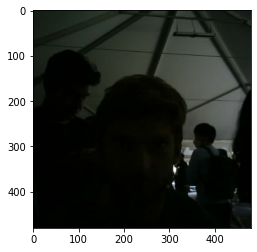

In [424]:
plt.imshow(image)

In [386]:
# SHADING APP
def image_stream(arduino):
    buffer_size = 1000;

    # Receive Length
    length = 0
    while arduino.inWaiting() == 0:
        pass
    length = int(arduino.read_until().decode())
    print(length)
    # Stream Chunks
    image_bytes = bytearray()
    chunks = length // 1000
    x = 0
    while x < chunks:
        while arduino.inWaiting() < 1000:
            pass
        bts = arduino.read(1000)
        image_bytes.extend(bts)
        x+=1
    while arduino.inWaiting() < length%1000:
        pass
    image_bytes.extend(arduino.read(length % 1000))
    
    print(image_bytes[-1])
    image_bytes = np.array(list(image_bytes))
    image = np.reshape(image_bytes, (64,128))
    
    
    # Turn off the stream
    return image




# ESTABLISH COMMUNICATION
port = find_arduino()
arduino = serial.Serial(port, baudrate=921600)
print(arduino.read_all().decode())


# SERIAL INTERFACE
while True:
    while arduino.inWaiting() == 0:
        pass
    msg = arduino.read_until().decode().rstrip()
    print(msg)
    
    if (msg == "CMD: STREAM IMAGE"):
        image = image_stream(arduino)
    if ("NANO-> LOOP END IN:" in msg):
        clear_output(wait=True)


Attempting to start Arducam
Starting capture
Image captured
Reading 9224 bytes from Arducam
Finished reading
CMD: STREAM IMAGE
9224
234


ValueError: cannot reshape array of size 9224 into shape (64,128)

TypeError: Invalid shape () for image data

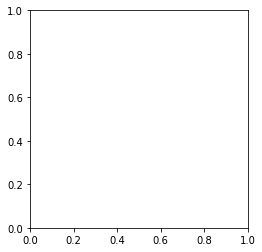

In [351]:
plt.imshow(image)

In [85]:
arduino.read_all()

b'NANO-> Image Sent\r\n'